In [1]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist, euclidean, cosine
from glob import glob

from model import vggvox_model
from wav_reader import get_fft_spectrum
import constants as c

Using TensorFlow backend.


In [2]:
model = vggvox_model()
model.load_weights(c.WEIGHTS_FILE)
model.summary()

Model: "VGGVox"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, None, 1)      0         
_________________________________________________________________
pad1 (ZeroPadding2D)         (None, 514, None, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 254, None, 96)     4800      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 254, None, 96)     384       
_________________________________________________________________
relu1 (Activation)           (None, 254, None, 96)     0         
_________________________________________________________________
mpool1 (MaxPooling2D)        (None, 126, None, 96)     0         
_________________________________________________________________
pad2 (ZeroPadding2D)         (None, 128, None, 96)     0    

In [3]:
def build_buckets(max_sec, step_sec, frame_step):
	buckets = {}
	frames_per_sec = int(1/frame_step)
	end_frame = int(max_sec*frames_per_sec)
	step_frame = int(step_sec*frames_per_sec)
	for i in range(0, end_frame+1, step_frame):
		s = i
		s = np.floor((s-7+2)/2) + 1  # conv1
		s = np.floor((s-3)/2) + 1  # mpool1
		s = np.floor((s-5+2)/2) + 1  # conv2
		s = np.floor((s-3)/2) + 1  # mpool2
		s = np.floor((s-3+2)/1) + 1  # conv3
		s = np.floor((s-3+2)/1) + 1  # conv4
		s = np.floor((s-3+2)/1) + 1  # conv5
		s = np.floor((s-3)/2) + 1  # mpool5
		s = np.floor((s-1)/1) + 1  # fc6
		if s > 0:
			buckets[i] = int(s)
	return buckets

In [4]:
def get_embeddings_from_list_file(model, list_file, max_sec):
	buckets = build_buckets(max_sec, c.BUCKET_STEP, c.FRAME_STEP)
	result = pd.read_csv(list_file, delimiter=",")
	result['features'] = result['filename'].apply(lambda x: get_fft_spectrum(x, buckets))
	result['embedding'] = result['features'].apply(lambda x: np.squeeze(model.predict(x.reshape(1,*x.shape,1))))
	return result[['filename','speaker','embedding']]

In [5]:
# print("Processing enroll samples....")
# enroll_result = get_embeddings_from_list_file(model, c.ENROLL_LIST_FILE, c.MAX_SEC)
# enroll_embs = np.array([emb.tolist() for emb in enroll_result['embedding']])
# speakers = enroll_result['speaker']

# print("Processing test samples....")
# test_result = get_embeddings_from_list_file(model, c.TEST_LIST_FILE, c.MAX_SEC)
# test_embs = np.array([emb.tolist() for emb in test_result['embedding']])

# print("Comparing test samples against enroll samples....")
# distances = pd.DataFrame(cdist(test_embs, enroll_embs, metric=c.COST_METRIC), columns=speakers)

# scores = pd.read_csv(c.TEST_LIST_FILE, delimiter=",",header=0,names=['test_file','test_speaker'])
# scores = pd.concat([scores, distances],axis=1)
# scores['result'] = scores[speakers].idxmin(axis=1)
# scores['correct'] = (scores['result'] == scores['test_speaker'])*1. # bool to int

# print("Writing outputs to [{}]....".format(c.RESULT_FILE))
# result_dir = os.path.dirname(c.RESULT_FILE)
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)
# with open(c.RESULT_FILE, 'w') as f:
#     scores.to_csv(f, index=False)

In [6]:
# scores

In [14]:
# make TIMIT-sample dataset
from glob import glob
from pathlib import Path

from pandas import DataFrame

EXCLUDE_FILES = ["sa1.wav", "sa2.wav"]

trainIDList = []
trainFileList = []
testIDlist = []
testFileList = []

speakerDirectories = glob("/home/ratthapon/TIMIT/timit/train/*/")

for speakerDirectory in speakerDirectories:
    speakerID = Path(speakerDirectory).name
    
    wavFiles = glob(speakerDirectory + "/*.wav")
    nWavFile = len(wavFiles)
    
    fileIndex = 0
    for wavFile in wavFiles:
        if Path(wavFile).name in EXCLUDE_FILES:
            # skip this files
            continue
            
        if fileIndex < (nWavFile-2)/2:
            trainIDList += [speakerID]
            trainFileList += [wavFile]
            print("Train", Path(wavFile).name)
            
        if fileIndex >= (nWavFile-2)/2:
            testIDlist += [speakerID]
            testFileList += [wavFile]
            print("Test", Path(wavFile).name)
            
        fileIndex += 1
        
trainingSet = DataFrame({
    "speaker": trainIDList,
    "filename": trainFileList
}) 
testingSet = DataFrame({
    "speaker": testIDlist,
    "filename": testFileList
})

trainingSet.to_csv("cfg/enroll_list_timit.csv", columns = ["filename", "speaker"], index = False)
testingSet.to_csv("cfg/test_list_timit.csv", columns = ["filename", "speaker"], index = False)
        

Train si538.wav
Train sx268.wav
Train sx448.wav
Train sx88.wav
Test si1295.wav
Test si1798.wav
Test sx358.wav
Test sx178.wav
Train sx82.wav
Train sx262.wav
Train sx352.wav
Train sx442.wav
Test sx172.wav
Test si2242.wav
Test si982.wav
Test si1612.wav
Train sx414.wav
Train sx144.wav
Train sx234.wav
Train si2214.wav
Test sx324.wav
Test si2207.wav
Test si954.wav
Test sx54.wav
Train sx114.wav
Train sx294.wav
Train sx204.wav
Train si1194.wav
Test sx24.wav
Test si1824.wav
Test sx384.wav
Test si564.wav
Train sx6.wav
Train sx186.wav
Train si1086.wav
Train sx366.wav
Test sx96.wav
Test si658.wav
Test sx276.wav
Test si456.wav
Train si1063.wav
Train si1693.wav
Train sx73.wav
Train sx433.wav
Test sx343.wav
Test si2323.wav
Test sx253.wav
Test sx163.wav
Train sx425.wav
Train sx65.wav
Train si1955.wav
Train si1325.wav
Test sx245.wav
Test sx155.wav
Test sx335.wav
Test si695.wav
Train sx248.wav
Train si1058.wav
Train si1688.wav
Train sx68.wav
Test si2318.wav
Test sx338.wav
Test sx158.wav
Test sx428.wav
T

In [15]:
TIMIT_ENROLL_LIST = "cfg/enroll_list_timit.csv"
TIMIT_TEST_LIST = "cfg/test_list_timit.csv"
TIMIT_RESULT = "res/test_list_timit.csv"

print("Processing enroll samples....")
enroll_result = get_embeddings_from_list_file(model, TIMIT_ENROLL_LIST, c.MAX_SEC)
enroll_embs = np.array([emb.tolist() for emb in enroll_result['embedding']])
speakers = enroll_result['speaker']

print("Processing test samples....")
test_result = get_embeddings_from_list_file(model, TIMIT_TEST_LIST, c.MAX_SEC)
test_embs = np.array([emb.tolist() for emb in test_result['embedding']])

print("Comparing test samples against enroll samples....")
distances = pd.DataFrame(cdist(test_embs, enroll_embs, metric=c.COST_METRIC), columns=speakers)

scores = pd.read_csv(TIMIT_TEST_LIST, delimiter=",",header=0,names=['test_file','test_speaker'])
scores = pd.concat([scores, distances],axis=1)
scores['result'] = scores[speakers].idxmin(axis=1)
scores['correct'] = (scores['result'] == scores['test_speaker'])*1. # bool to int

print("Writing outputs to [{}]....".format(TIMIT_RESULT))
result_dir = os.path.dirname(TIMIT_RESULT)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
with open(TIMIT_RESULT, 'w') as f:
    scores.to_csv(f, index=False)

Processing enroll samples....
Processing test samples....
Comparing test samples against enroll samples....
Writing outputs to [res/test_list_timit.csv]....


In [16]:
# Realize Evaluation Metrices
from sklearn.metrics import classification_report

print(classification_report(scores["test_speaker"], scores["result"]))

              precision    recall  f1-score   support

   dr1-fvmh0       1.00      1.00      1.00         4
   dr1-mcpm0       1.00      1.00      1.00         4
   dr2-faem0       1.00      1.00      1.00         4
   dr2-marc0       1.00      1.00      1.00         4
   dr3-falk0       1.00      1.00      1.00         4
   dr3-madc0       1.00      1.00      1.00         4
   dr4-falr0       1.00      1.00      1.00         4
   dr4-maeb0       0.80      1.00      0.89         4
   dr5-ftlg0       1.00      1.00      1.00         4
   dr5-mbgt0       1.00      0.75      0.86         4
   dr6-fapb0       1.00      1.00      1.00         4
   dr6-mbma1       1.00      0.75      0.86         4
   dr7-fblv0       1.00      1.00      1.00         4
   dr7-madd0       1.00      0.75      0.86         4
   dr8-fbcg1       1.00      1.00      1.00         4
   dr8-mbcg0       0.67      1.00      0.80         4

    accuracy                           0.95        64
   macro avg       0.97   

Text(0.5, 1, 'Confusion Matrix')

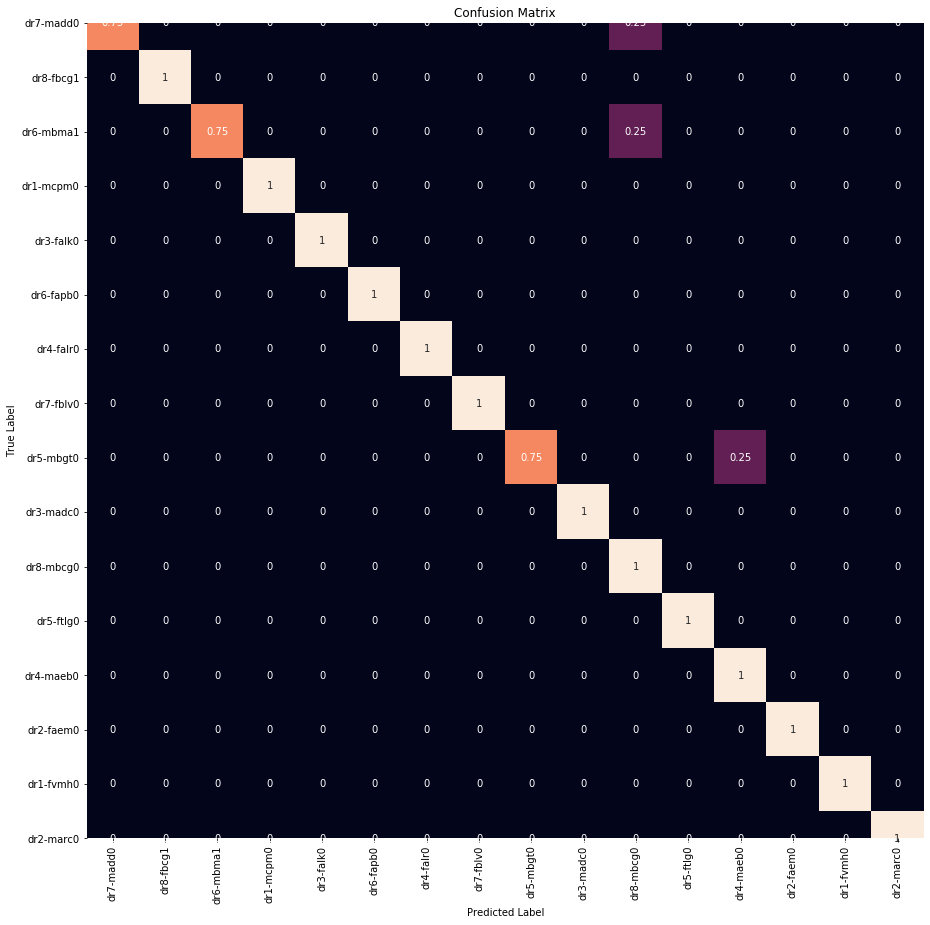

In [17]:
# Visualize Metrices

import matplotlib.pyplot as figure
import seaborn

from sklearn.metrics import confusion_matrix

uniqueSpeakers = speakers.unique()
cm = confusion_matrix(scores["test_speaker"], scores["result"], labels = uniqueSpeakers)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

figure.figure(figsize = (15,15))
seaborn.heatmap(cm, annot = True, cbar = False, xticklabels = uniqueSpeakers, yticklabels = uniqueSpeakers)
figure.ylabel('True Label')
figure.xlabel('Predicted Label')
figure.title('Confusion Matrix')